# Vegetation phenology <img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with both the `NCI` and `DEA Sandbox` environments
* **Products used:** 
[ga_s2am_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_s2am_ard_3), 
[ga_s2bm_ard_3](https://explorer.sandbox.dea.ga.gov.au/ga_s2bm_ard_3)


## Background
Phenology is the study of plant and animal life cycles in the context of the seasons.
It can be useful in understanding the life cycle trends of crops and how the growing seasons are affected by changes in climate.
For more information, see the [USGS page on deriving phenology from NDVI time-series](https://www.usgs.gov/land-resources/eros/phenology/science/deriving-phenological-metrics-ndvi?qt-science_center_objects=0#qt-science_center_objects)

## Description

This notebook demonstrates how to calculate vegetation phenology statistics using the DEA function [xr_phenology](../Tools/dea_tools/temporal.py). To detect changes in plant life using satellite images, the script uses either the **Normalized Difference Vegetation Index (NDVI)** or the **Enhanced Vegetation Index (EVI)**, which are common proxies for vegetation growth and health.

The outputs of this notebook can be used to assess spatio-temporal differences in the growing seasons of agriculture fields or native vegetation.

This notebook demonstrates the following steps:

1. Load cloud-masked Sentinel 2 data for an area of interest.
2. Calculate a vegetation proxy index (NDVI or EVI).
3. Generate a zonal time series of vegetation health
4. Complete and smooth the vegetation timeseries to remove gaps and noise.
5. Calculate phenology statistics on a simple 1D vegetation time series
6. Calculate per-pixel phenology statistics
7. Optional: Calculating generic temporal statistics usng the `hdstats` library

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import os
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import datetime as dt
import matplotlib.pyplot as plt

from dea_tools.temporal import xr_phenology, temporal_statistics
from dea_tools.datahandling import load_ard
from dea_tools.bandindices import calculate_indices
from dea_tools.plotting import display_map, rgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app='Vegetation_phenology')


### Analysis parameters

The following cell sets important parameters for the analysis:

* `veg_proxy`: Band index to use as a proxy for vegetation health e.g. `'NDVI'` or `'EVI'`
* `lat`: The central latitude to analyse (e.g. `-10.6996`).
* `lon`: The central longitude to analyse (e.g. `35.2708`).
* `buffer`: The number of square degrees to load around the central latitude and longitude.
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The year range to analyse (e.g. `('2019-01', '2019-06')`).



In [3]:
# Set the vegetation proxy to use
veg_proxy = 'NDVI'

# Define area of interest
lat = -33.3631
lon = 121.2050
lon_buffer = 0.023
lat_buffer = 0.0075

# Set the range of dates for the analysis
time_range = ('2019-01-01', '2020-12-20')

In [4]:
# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-lat_buffer, lat+lat_buffer)
lon_range = (lon-lon_buffer, lon+lon_buffer)

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
display_map(x=lon_range, y=lat_range)

## Load cloud-masked Sentinel-2 data

The first step is to load Sentinel-2 data for the specified area of interest and time range. 
The `load_ard` function is used here to load data that has been masked for cloud, shadow and quality filters, making it ready for analysis.

In [6]:
# Create a reusable query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'measurements': ['nbart_red', 'nbart_green', 'nbart_blue', 'nbart_nir_1'],
    'resolution': (-20, 20),
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}

# Load available data from Sentinel-2
ds = load_ard(
    dc=dc,
    products=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
    skip_broken_datasets=True,
    **query,
)

print(ds)

Finding datasets
    ga_s2am_ard_3
    ga_s2bm_ard_3
Applying pixel quality/cloud mask
Loading 287 time steps


CPLReleaseMutex: Error = 1 (Operation not permitted)


<xarray.Dataset>
Dimensions:      (time: 287, y: 81, x: 222)
Coordinates:
  * time         (time) datetime64[ns] 2019-01-01T02:06:37.098000 ... 2020-12...
  * y            (y) float64 -4.024e+06 -4.024e+06 ... -4.026e+06 -4.026e+06
  * x            (x) float64 1.169e+07 1.169e+07 1.169e+07 ... 1.17e+07 1.17e+07
    spatial_ref  int32 6933
Data variables:
    nbart_red    (time, y, x) float32 1.904e+03 2.105e+03 ... 2.875e+03
    nbart_green  (time, y, x) float32 1.43e+03 1.57e+03 ... 2.397e+03 2.332e+03
    nbart_blue   (time, y, x) float32 1.133e+03 1.23e+03 ... 1.939e+03 1.931e+03
    nbart_nir_1  (time, y, x) float32 2.543e+03 2.765e+03 ... 3.565e+03
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


**Once the load is complete**, we can plot some of the images as as a true-colour image using the `rgb` function.  

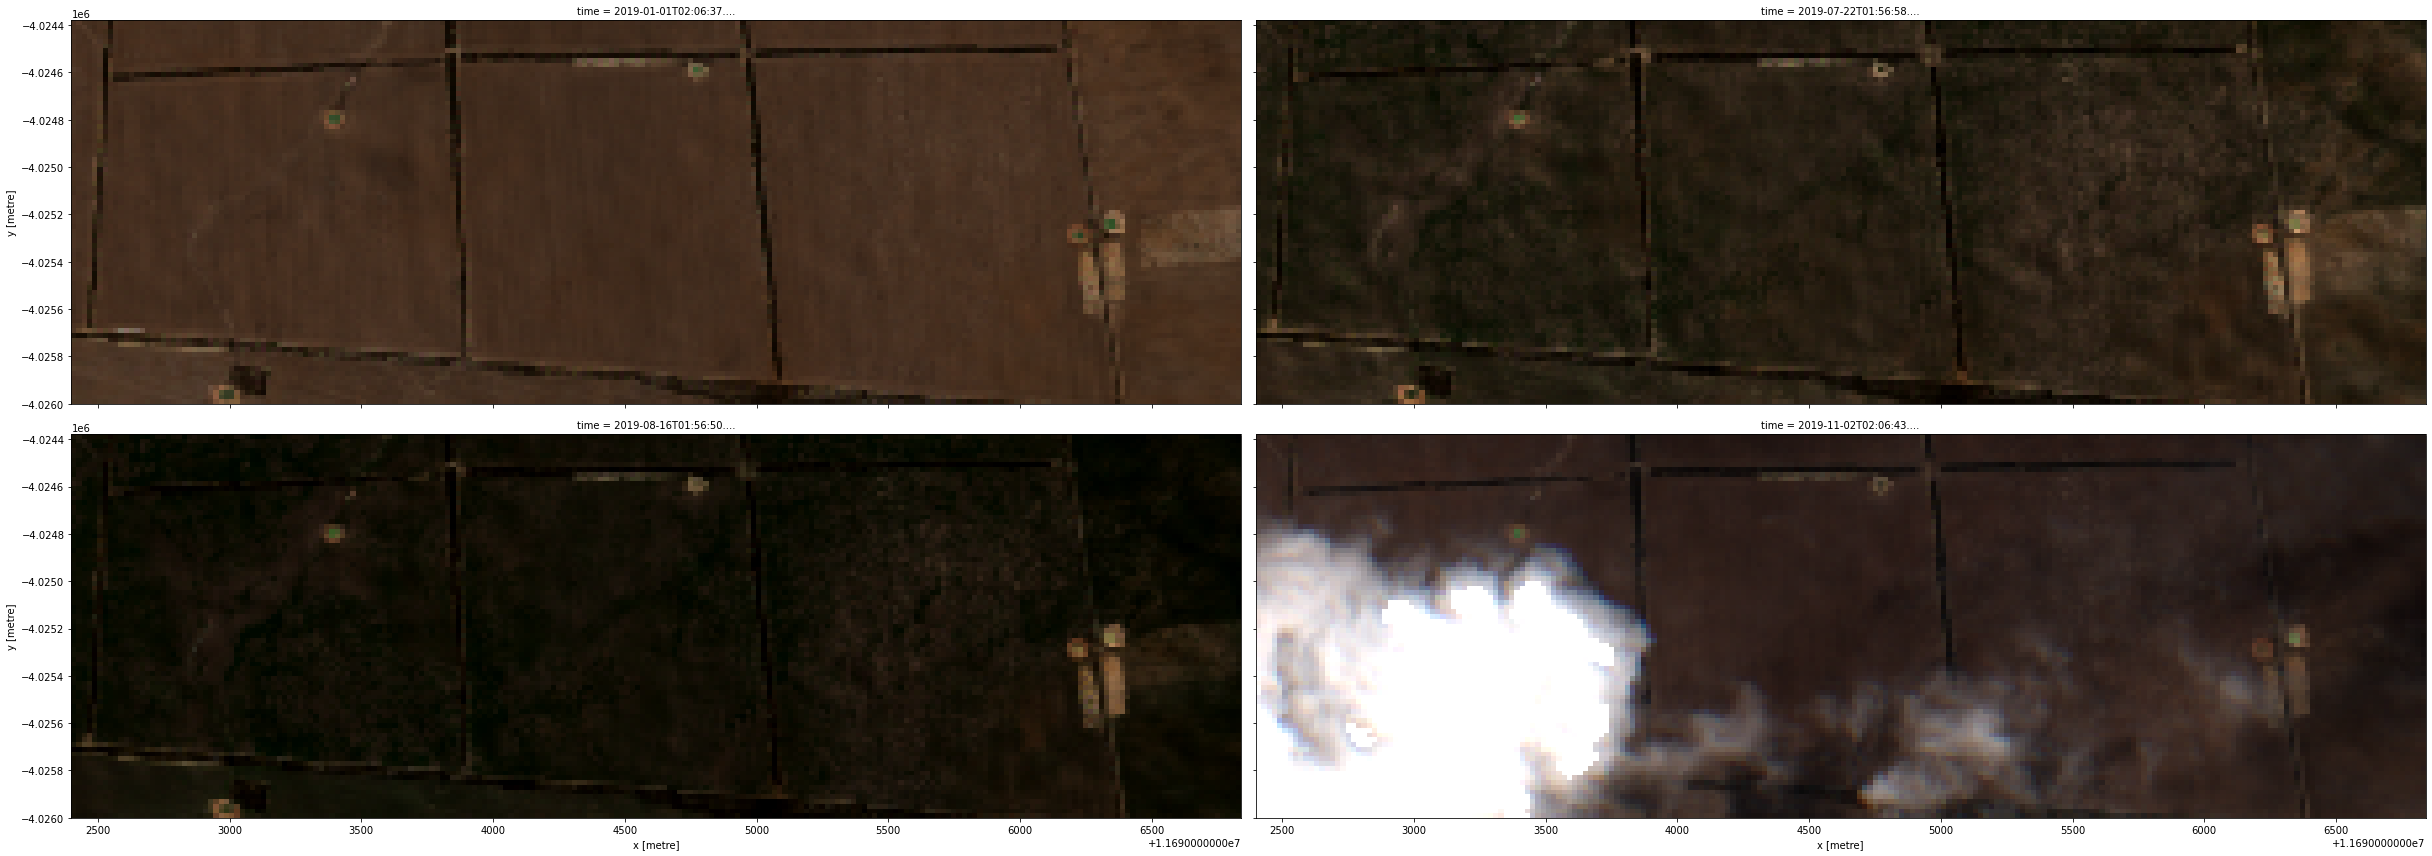

In [7]:
rgb(ds, index=[0, 80, 90, 121], col_wrap=2)

## Compute band indices

This study measures the presence of vegetation through either the `normalised difference vegetation index (NDVI)` or the `enhanced vegetation index (EVI)`.
The index that will be used is dictated by the `veg_proxy` parameter that was set in the "Analysis parameters" section.

The normalised difference vegetation index (NDVI) requires the `red` and `nir` (near-infra red) bands. 
The formula is

$$
\begin{aligned}
\text{NDVI} & = \frac{(\text{NIR} - \text{Red})}{(\text{NIR} + \text{Red})} \\
\end{aligned}
$$

The Enhanced Vegetation Index requires the `red`, `nir` and `blue` bands.
The formula is

$$
\begin{aligned}
\text{EVI} & = \frac{2.5 \times (\text{NIR} - \text{Red})}{(\text{NIR} + 6 \times \text{Red} - 7.5 \times \text{Blue} + 1)} \\
\end{aligned}
$$


Both indices are available through the [calculate_indices](../Frequently_used_code/Calculating_band_indices.ipynb) function, imported from [dea_tools.bandindices](https://github.com/GeoscienceAustralia/dea-notebooks/blob/develop/Tools/dea_tools/bandindices.py).
Here, we use `collection='ga_s2_1'` since we're working with Sentinel-2 data.

In [8]:
# Calculate the chosen vegetation proxy index and add it to the loaded data set
ds = calculate_indices(ds, index=veg_proxy, collection='ga_s2_1')

The vegetation proxy index should now appear as a data variable, along with the loaded measurements, in the `ds` object.

## Plot the vegetation index over time

To get an idea of how the vegetation health changes throughout the year(s), we can plot a zonal time series over the region of interest. First we will do a simple plot of the zonal mean of the data.  


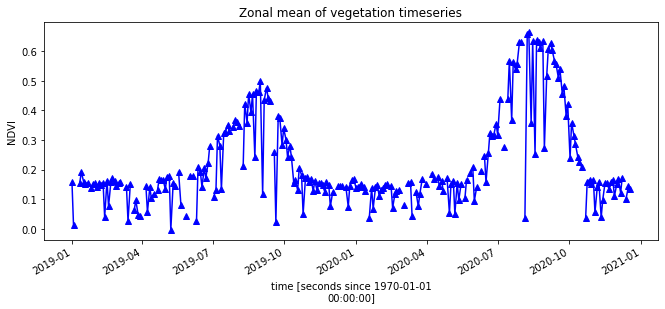

In [9]:
ds.NDVI.mean(['x', 'y']).plot.line('b-^', figsize=(11,4))
plt.title('Zonal mean of vegetation timeseries');

## Smoothing/Interpolating vegetation time-series

Here, we will smooth and interpolate the data to ensure we working with a consistent time-series. This is a very important step in the workflow and there are many ways to smooth, interpolate, gap-fill, remove outliers, or curve-fit the data to ensure a useable time-series. If not using the default example, you may have to define additional methods to those used here.

To do this we take two steps:

1. Resample the data to fortnightly time-steps using the fortnightly median
2. Calculate a rolling mean with a window of 4 steps

In [10]:
resample_period='2W'
window=4

veg_smooth=ds[veg_proxy].resample(time=resample_period).median().rolling(time=window, min_periods=1).mean()


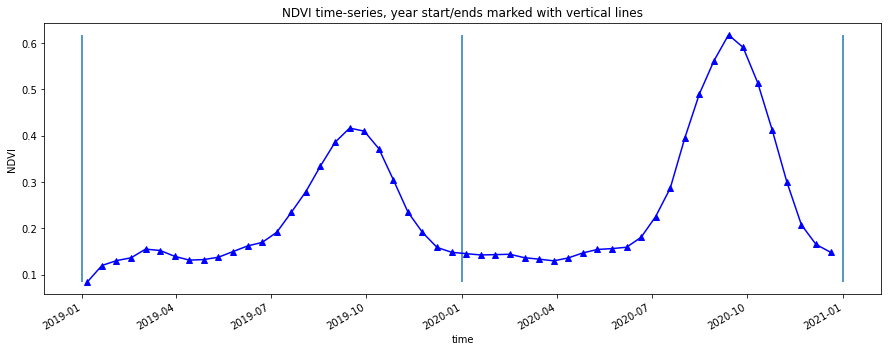

In [11]:
veg_smooth_1D = veg_smooth.mean(['x', 'y'])
veg_smooth_1D.plot.line('b-^', figsize=(15,5))
_max=veg_smooth_1D.max()
_min=veg_smooth_1D.min()
plt.vlines(np.datetime64('2019-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2020-01-01'), ymin=_min, ymax=_max)
plt.vlines(np.datetime64('2021-01-01'), ymin=_min, ymax=_max)
plt.title(veg_proxy+' time-series, year start/ends marked with vertical lines')
plt.ylabel(veg_proxy);

## Calculate phenology statistics using `xr_phenology`

The DEA function `xr_phenology` can calculate a number of land-surface phenology statistics that together describe the characteristics of a plant's lifecycle.  The function can calculate the following statistics on either a zonal timeseries (like the one above), or on a per-pixel basis:

            SOS = DOY of start of season
            POS = DOY of peak of season
            EOS = DOY of end of season
            vSOS = Value at start of season
            vPOS = Value at peak of season
            vEOS = Value at end of season
            Trough = Minimum value of season
            LOS = Length of season (DOY)
            AOS = Amplitude of season (in value units)
            ROG = Rate of greening
            ROS = Rate of senescence

where DOY = day-of-year (Jan 1st = 0, Dec 31st = 365).  By default the function will return all the statistics as an `xarray.Dataset`, to return only a subset of these statistics pass a list of the desired statistics to the function e.g. `stats=['SOS', 'EOS', 'ROG']`.

The `xr_phenology` function also allows for interpolating and/or smoothing the time-series in the same way as we did above, the interpolating/smoothing will occur before the statistics are calculated. 

See the [dea_tools.temporal](../Tools/dea_tools/temporal.py) script for more information on each of the parameters in `xr_phenology`.


### Zonal phenology statistics

To help us understand what these statistics refer too, lets first pass the simpler zonal mean (mean of all pixels in the image) time-series to the function and plot the results on the same curves as above.

First, provide a list of statistics to calculate with the parameter, `pheno_stats`.

`method_sos` : If 'first' then vSOS is estimated as the first positive slope on the greening side of the curve. If 'median', then vSOS is estimated as the median value of the postive slopes on the greening side of the curve.

`method_eos` : If 'last' then vEOS is estimated as the last negative slope on the senescing side of the curve. If 'median', then vEOS is estimated as the 'median' value of the negative slopes on the senescing side of the curve.

In [12]:
pheno_stats = ['SOS','vSOS','POS','vPOS','EOS','vEOS','Trough','LOS','AOS','ROG','ROS']
method_sos = 'median'
method_eos = 'median'

Calculate phenology stats for each year in the data

In [13]:
# find all the years to assist with plotting
years=veg_smooth_1D.groupby('time.year')

# get list of years in ts to help with looping
years_int=[y[0] for y in years]

#store results in dict
pheno_results = {}

#loop through years and calculate phenology
for year in years_int:
    #select year
    da = dict(years)[year]
    
    #calculate stats
    stats=xr_phenology(
            da,
            method_sos=method_sos,
            method_eos=method_eos,
            stats=pheno_stats,
            verbose=False
                )
    #add results to dict    
    pheno_results[str(year)] = stats
    
for key,value in pheno_results.items():
    print('Year: ' +key)
    for b in value.data_vars:
        print("   "+b+": ", round(float(value[b].values),3))

Year: 2019
   SOS:  146.0
   vSOS:  0.15
   POS:  258.0
   vPOS:  0.416
   EOS:  314.0
   vEOS:  0.235
   Trough:  0.084
   LOS:  168.0
   AOS:  0.332
   ROG:  0.002
   ROS:  -0.003
Year: 2020
   SOS:  145.0
   vSOS:  0.156
   POS:  257.0
   vPOS:  0.618
   EOS:  313.0
   vEOS:  0.3
   Trough:  0.13
   LOS:  168.0
   AOS:  0.488
   ROG:  0.004
   ROS:  -0.006


Plot the results with our statistcs annotated on the plot

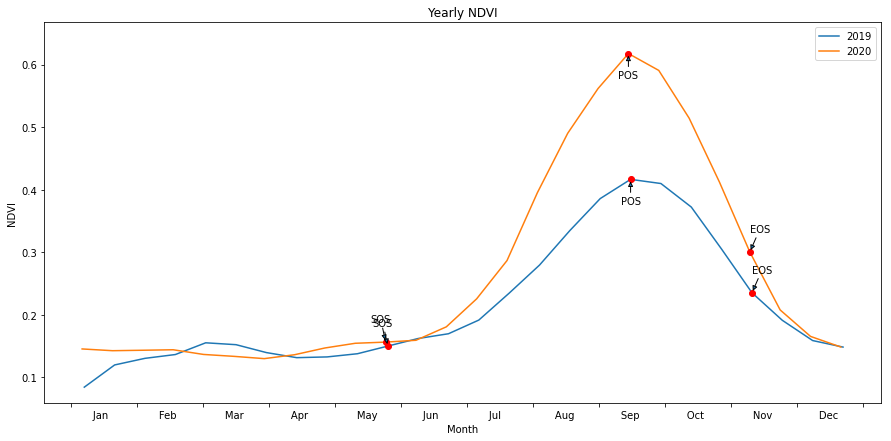

In [14]:
# find all the years to assist with plotting
years=veg_smooth_1D.groupby('time.year')

fig, ax = plt.subplots()
fig.set_size_inches(15,7)
for year, y in zip(years, years_int):
    #grab tall the values we need for plotting
    eos = pheno_results[str(y)].EOS.values
    sos = pheno_results[str(y)].SOS.values
    pos = pheno_results[str(y)].POS.values

    veos = pheno_results[str(y)].vEOS.values
    vsos = pheno_results[str(y)].vSOS.values
    vpos = pheno_results[str(y)].vPOS.values
    
    #create plot
    #the groupby and mean below doesn't actually do anything, except allow
    #the plots to be on the same x-axis. i.e. veg-data isn't modified, just time units
    year[1].groupby('time.dayofyear').mean().plot(ax=ax, label=year[0])

    #add start of season
    ax.plot(sos, vsos, 'or')
    ax.annotate('SOS',
                xy=(sos, vsos),
                xytext=(-15, 20),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='-|>'))

    #add end of season
    ax.plot(eos, veos, 'or')
    ax.annotate('EOS',
                xy=(eos, veos),
                xytext=(0, 20),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='-|>'))

    #add peak of season
    ax.plot(pos, vpos, 'or')
    ax.annotate('POS',
                xy=(pos, vpos),
                xytext=(-10, -25),
                textcoords='offset points',
                arrowprops=dict(arrowstyle='-|>'))

ax.legend()
plt.ylim(_min-0.025,_max.values+0.05)
month_abbr=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec', '']
new_m=[]
for m in month_abbr:
    new_m.append('       %s'%m) #Add spaces before the month name
plt.xticks(np.linspace(0,365,13), new_m, horizontalalignment='left')
plt.xlabel('Month')
plt.ylabel(veg_proxy)
plt.title('Yearly '+veg_proxy);

## Per-pixel phenology statistics

We can now calculate the statistics for every pixel in our time-series and plot the results.

In [15]:
# find all the years to assist with plotting
years=veg_smooth.groupby('time.year')

# get list of years in ts to help with looping
years_int=[y[0] for y in years]

#store results in dict
pheno_results = {}

#loop through years and calculate phenology
for year in years_int:
    #select year
    da = dict(years)[year]
    
    #calculate stats
    stats=xr_phenology(
            da,
            method_sos=method_sos,
            method_eos=method_eos,
            stats=pheno_stats,
            verbose=False
                )
    #add results to dict    
    pheno_results[str(year)] = stats

The phenology statistics have been calculated seperately for every pixel in the image.  Let's plot each of them to see the results. 

Below, pick a year from the phenology results to plot. 

In [16]:
#Pick a year to plot
year_to_plot = '2020'


At the top if the plotting code we re-mask the phenology results with the crop-mask. This is because `xr_phenology`has methods for handling pixels with only NaNs (such as those regions outside of the polygon mask), so the results can have phenology results for regions outside the mask. We will therefore have to mask the data again.

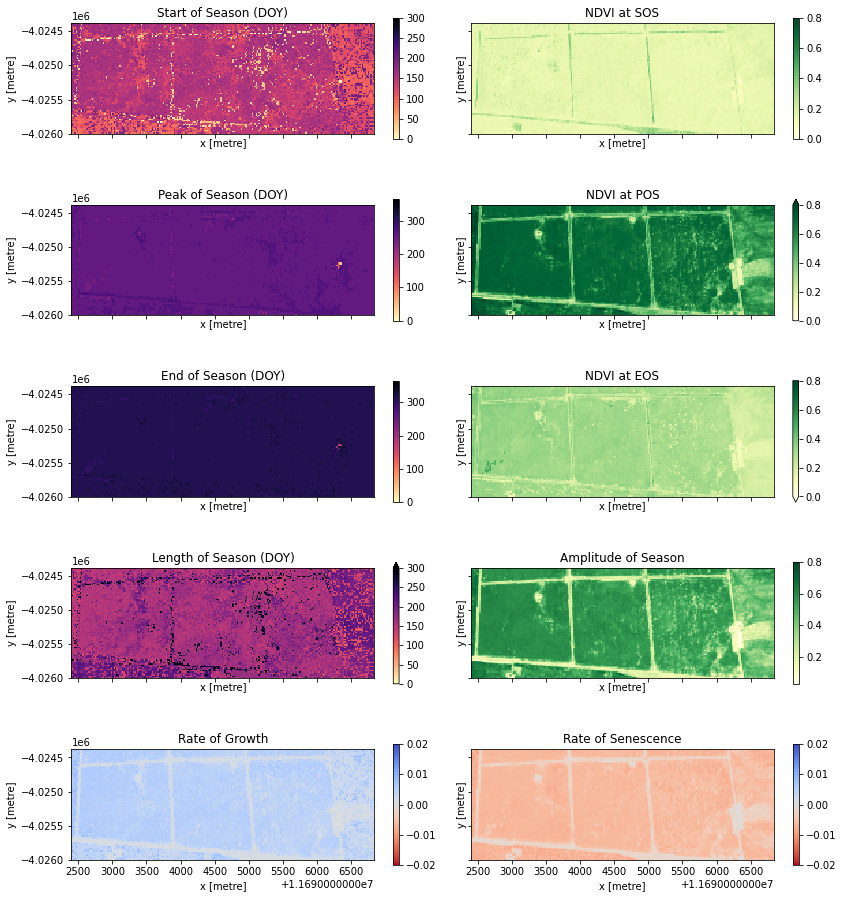

In [17]:
#select the year to plot
phen = pheno_results[year_to_plot]

# Set up figure
fig, ax = plt.subplots(nrows=5,
                       ncols=2,
                       figsize=(12, 13),
                       sharex=True,
                       sharey=True)

# Set colorbar size
cbar_size = 0.7

# Set aspect ratios
for a in fig.axes:
    a.set_aspect('equal')

# Start of season
phen.SOS.plot(ax=ax[0, 0],
              cmap='magma_r',
              vmax=300,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 0].set_title('Start of Season (DOY)')
phen.vSOS.plot(ax=ax[0, 1],
               cmap='YlGn',
               vmax=0.8,
               vmin=0,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[0, 1].set_title(veg_proxy + ' at SOS')

# Peak of season
phen.POS.plot(ax=ax[1, 0],
              cmap='magma_r',
              vmax=365,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 0].set_title('Peak of Season (DOY)')
phen.vPOS.plot(ax=ax[1, 1],
               cmap='YlGn',
               vmax=0.8,
               vmin=0,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[1, 1].set_title(veg_proxy + ' at POS')

# End of season
phen.EOS.plot(ax=ax[2, 0],
              cmap='magma_r',
              vmax=365,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[2, 0].set_title('End of Season (DOY)')
phen.vEOS.plot(ax=ax[2, 1],
               cmap='YlGn',
               vmax=0.8,
               vmin=0,
               cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[2, 1].set_title(veg_proxy + ' at EOS')

# Length of Season
phen.LOS.plot(ax=ax[3, 0],
              cmap='magma_r',
              vmax=300,
              vmin=0,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[3, 0].set_title('Length of Season (DOY)')

# Amplitude
phen.AOS.plot(ax=ax[3, 1],
              cmap='YlGn',
              vmax=0.8,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[3, 1].set_title('Amplitude of Season')

# Rate of growth
phen.ROG.plot(ax=ax[4, 0],
              cmap='coolwarm_r',
              vmin=-0.02,
              vmax=0.02,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[4, 0].set_title('Rate of Growth')

# Rate of Sensescence
phen.ROS.plot(ax=ax[4, 1],
              cmap='coolwarm_r',
              vmin=-0.02,
              vmax=0.02,
              cbar_kwargs=dict(shrink=cbar_size, label=None))
ax[4, 1].set_title('Rate of Senescence')

plt.tight_layout();

## Conclusions

In the example above, we can see these four fields are following the same cropping schedule and are therefore likely the same species of crop. We can also observe intra-field differences in the rates of growth, and in the NDVI values at different times of the season, which may be attributable to differences in soil quality, watering intensity, or other farming practices. 

Phenology statistics are a powerful way to summarise the seasonal cycle of a plant's life.  Per-pixel plots of phenology can help us understand the timing of vegetation growth and sensecence across large areas and across diverse plant species as every pixel is treated as an independent series of observations. This could be important, for example, if we wanted to assess how the growing seasons are shifting as the climate warms.  


## Advanced: Calculating generic temporal statistics

In addition to the `xr_phenology` function, the DEA [dea_tools.temporal](../Tools/dea_tools/temporal.py) script contains another function for calculating generic time-series statistics, `temporal_statistics`.  This function is built upon the [hdstats library](https://github.com/daleroberts/hdstats) (a library of multivariate and high-dimensional statistics algorithms).
This function accepts a 2 or 3D time-series of, for example, NDVI, and computes a number of summary statistics including:
- discordance
- discrete fourier transform coefficients (mean, std, and median)
- median change
- absolute change
- complexity
- central difference
- number of peaks (very slow to run)

Below we will calculate a number of these statistics and plot them.

In [18]:
statistics = ['discordance',
             'f_mean',
             'median_change',
             'abs_change',
             'complexity',
             'central_diff']

ts_stats = temporal_statistics(veg_smooth, statistics)
print(ts_stats)

   Statistics:
      discordance
      f_mean
      median_change
      abs_change
      complexity
      central_diff
<xarray.Dataset>
Dimensions:        (x: 222, y: 81)
Coordinates:
  * x              (x) float64 1.169e+07 1.169e+07 ... 1.17e+07 1.17e+07
  * y              (y) float64 -4.024e+06 -4.024e+06 ... -4.026e+06 -4.026e+06
Data variables:
    discordance    (y, x) float32 -0.01539 -0.05065 ... -0.04094 -0.04418
    f_mean_n1      (y, x) float32 2.429 1.629 2.34 2.45 ... 1.564 1.512 1.418
    f_mean_n2      (y, x) float32 0.3558 0.2041 0.4218 ... 0.4883 0.5206 0.4982
    f_mean_n3      (y, x) float32 0.02586 0.03168 0.03384 ... 0.03774 0.03939
    median_change  (y, x) float32 -0.0002748 0.001233 ... -0.002687 -0.002015
    abs_change     (y, x) float32 0.03462 0.0252 0.03708 ... 0.03441 0.03375
    complexity     (y, x) float32 6.013 6.043 6.409 6.228 ... 8.163 8.551 8.576
    central_diff   (y, x) float32 -0.0005502 -0.0006245 ... -0.0004846 -0.000492


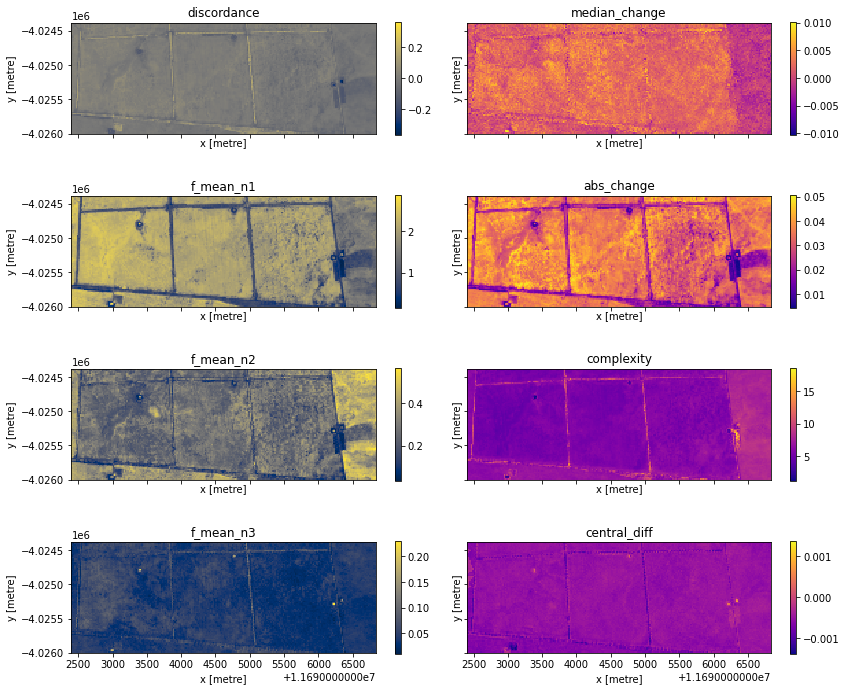

In [19]:
# set up figure
fig, axes = plt.subplots(nrows=4,
                         ncols=2,
                         figsize=(12, 10),
                         sharex=True,
                         sharey=True)

# Set colorbar size
cbar_size = 0.5

# Set aspect ratios
for a in fig.axes:
    a.set_aspect('equal')

# Set colorbar size
cbar_size = 0.7
stats = list(ts_stats.data_vars)

# Plot
for ax, stat_1, stat_2 in zip(axes, stats[0:4], stats[4:8]):
    ts_stats[stat_1].plot(ax=ax[0],
                          cmap='cividis',
                          cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[0].set_title(stat_1)

    ts_stats[stat_2].plot(ax=ax[1],
                          cmap='plasma',
                          cbar_kwargs=dict(shrink=cbar_size, label=None))
    ax[1].set_title(stat_2)

plt.tight_layout();

## Next steps

When you're done, if you wish to run this code for another region, return to the "Analysis parameters" cell, modify some values (e.g. `time_range`,  or `lat`/`lon`) and rerun the analysis.

For advanced users, `xr_phenology` could be used for generating phenology feature layers in a machine learning classifier (see [Machine Learning with ODC](../Frequently_used_code/Machine_learning_with_ODC.ipynb) for example of running ML models with ODC data). 
`xr_phenology` can be passed inside of the `custom_func` parameter in the `dea_tools.classification.collect_training_data()` function, allowing phenological statistics to be computed during the collection of training data. 
An example would look like this:

    from dea_tools.temporal import xr_phenology
    from dea_tools.classification import collect_training_data

    def phenology_stats(da):
        stats = xr_phenology(da)
        return stats

    training = collect_training_data(..., custom_func=phenology_stats)

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** March 2022

**Compatible datacube version:** 

In [20]:
print(datacube.__version__)

1.8.6


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)